<h1 align=center>Capítulo 7: Personalizando Modelos SpaCy</h1>
<p align=center><img src=https://blog.desdelinux.net/wp-content/uploads/2021/02/procesamiento-de-lenguaje-natural.png width=500></p>

Neste capítulo, você aprenderá a treinar, armazenar e usar componentes de pipeline estatísticos personalizados. Primeiro, discutiremos quando exatamente devemos realizar o treinamento de modelo personalizado. Em seguida, você aprenderá uma etapa fundamental do treinamento de modelos – como coletar e rotular seus próprios dados.

Neste capítulo, você também aprenderá a fazer o melhor uso do **Prodigy**, a ferramenta de anotação. Em seguida, você aprenderá como atualizar um componente de pipeline estatístico existente com seus próprios dados. Atualizaremos o componente **reconhecedor de entidade nomeada (NER)** do pipeline spaCy com nossos próprios dados rotulados.

Por fim, você aprenderá a criar um componente de pipeline estatístico do zero com seus próprios dados e rótulos. Para isso, voltaremos a treinar um modelo NER. Este capítulo apresenta uma prática completa de aprendizado de máquina, incluindo coleta de dados, anotação de dados e treinamento de um modelo para extração de informações.

Ao final deste capítulo, você estará pronto para treinar modelos spaCy em seus próprios dados. Você terá o conjunto completo de habilidades para coletar dados, pré-processar dados no formato que o spaCy pode reconhecer e, finalmente, treinar modelos spaCy com esses dados. Neste capítulo, abordaremos os seguintes tópicos principais:
 * Introdução à preparação de dados
 * Anotação e preparação de dados
 * Atualização de um componente de pipeline existente
 * Treinando um componente de pipeline do zero

## Introdução à preparação de dados
Nos capítulos anteriores, vimos como tirar o melhor proveito dos modelos estatísticos pré-treinados do spaCy (incluindo o **tagger POS**, **NER** e **analisador de dependência**) em nossos aplicativos. Neste capítulo, veremos como personalizar os modelos estatísticos para nosso domínio e dados personalizados.

Os modelos *spaCy* são muito bem-sucedidos para propósitos gerais de NLP, como entender a sintaxe de uma frase, dividir um parágrafo em frases e extrair algumas entidades. No entanto, às vezes, trabalhamos em domínios muito específicos que os modelos *spaCy* não viram durante o treinamento.

Por exemplo, o texto do Twitter contém muitas palavras não regulares, como *hashtags*, *emoticons* e *mentions*. Além disso, as frases do *Twitter* geralmente são apenas frases, não frases completas. Aqui, é inteiramente razoável que o tagger POS da spaCy funcione de maneira abaixo do padrão, já que o tagger POS é treinado em frases completas e gramaticalmente corretas em inglês.

Outro exemplo é o domínio médico. O domínio médico contém muitas entidades, como nomes de drogas, doenças e compostos químicos. Não se espera que essas entidades sejam reconhecidas pelo modelo NER da spaCy porque não possui rótulos de entidade de doença ou medicamento. O NER não sabe nada sobre o domínio médico.

Treinar seus modelos personalizados requer tempo e esforço. Antes mesmo de iniciar o processo de treinamento, você deve decidir se o treinamento é realmente necessário. Para determinar se você realmente precisa de treinamento personalizado, você precisará se fazer as seguintes perguntas:
* Os modelos spaCy funcionam bem o suficiente em seus dados?
* Seu domínio inclui muitos rótulos ausentes nos modelos spaCy?
* Já existe um modelo/aplicativo pré-treinado no GitHub ou em outro lugar? (Não gostaríamos de reinventar a roda.)

Vamos discutir essas questões em detalhes nas próximas seções.

### Os modelos spaCy funcionam bem o suficiente em seus dados?

Se o modelo tiver um desempenho suficientemente bom (acima de 0,75 de precisão), você poderá personalizar a saída do modelo por meio de outro componente spaCy. Por exemplo, digamos que trabalhamos no domínio de navegação e temos enunciados como os seguintes:
~~~python
navigate to my home
navigate to Oxford Street
~~~

Vamos ver quais entidades o modelo NER do spaCy gera para estas frases:

In [197]:
import spacy
nlp = spacy.load("en_core_web_md")
doc1 = nlp("navigate to my home")
doc1.ents

()

In [198]:
doc2 = nlp("navigate to Oxford Street")
doc2.ents

(Oxford Street,)

In [199]:
doc2.ents[0].label_

'LOC'

In [200]:
spacy.explain("LOC")

'Non-GPE locations, mountain ranges, bodies of water'

Aqui, **home** não é reconhecida como uma entidade, mas queremos que ela seja reconhecida como uma entidade de localização. Além disso, o modelo NER da spaCy rotula **Oxford Street** como **LOC**, o que significa uma entidade do tipo *Locais não GPE, cadeias de montanhas, corpos d'água*, o que não é o que queremos.

Queremos que esta entidade seja reconhecida como **GPE**, um local. Aqui, podemos treinar ainda mais o NER para reconhecer nomes de ruas como **GPE**, bem como reconhecer algumas palavras de localização, como *work, home, may mama's house*, como **GPE**.

Outro exemplo é o domínio do jornal. Nesse domínio, as entidades pessoa, local, data, hora e organização são extraídas, mas você precisa de mais um tipo de entidade – **veículo** (carro, ônibus, avião e assim por diante). Portanto, em vez de treinar do zero, você pode adicionar um novo tipo de entidade usando a **EntityRuler** do spaCy. Sempre examine seus dados primeiro e calcule a taxa de sucesso dos modelos spaCy. Se a taxa de sucesso for satisfatória, use outros componentes spaCy para personalizar.

### Seu domínio inclui muitos rótulos ausentes nos modelos spaCy?
Por exemplo, no exemplo de jornal anterior, apenas um rótulo de entidade, veículo, está faltando nos rótulos do modelo NER do spaCy. Outros tipos de entidade são reconhecidos. Nesse caso, você não precisa de treinamento personalizado.

Considere o domínio médico novamente. As entidades são doenças, sintomas, drogas, dosagens, nomes de compostos químicos e assim por diante. Esta é uma lista especializada e longa de entidades. Obviamente, para o domínio médico, você precisa de treinamento de modelo personalizado. Se precisarmos de treinamento de modelo personalizado, geralmente seguimos estas etapas:
1. Colete seus dados.
2. Anote seus dados.
3. Decida atualizar um modelo existente ou treine um modelo do zero.

Na etapa de coleta de dados, decidimos quantos dados coletar: 1.000 frases, 5.000 frases ou mais. A quantidade de dados depende da complexidade de sua tarefa e domínio. Normalmente, começamos com uma quantidade aceitável de dados, fazemos um primeiro treinamento de modelo e vemos como ele se comporta; então podemos adicionar mais dados e treinar novamente o modelo.

Depois de coletar seu conjunto de dados, você precisa anotar seus dados de forma que o código de treinamento spaCy os reconheça. Na próxima seção, veremos o formato dos dados de treinamento e como anotar dados com a ferramenta Prodigy do spaCy.

O terceiro ponto é decidir treinar um modelo em branco do zero ou fazer atualizações em um modelo existente. Aqui, a regra geral é a seguinte: se suas entidades/rótulos estão presentes no modelo existente, mas você não vê um desempenho muito bom, atualize o modelo com seus próprios dados, como no exemplo de navegação anterior. Se suas entidades não estiverem presentes no modelo spaCy atual, provavelmente você precisará de treinamento personalizado.
> #### DICA
> Não se apresse em treinar seus próprios modelos. Primeiro, examine se você realmente precisa personalizar os modelos. Sempre tenha em mente que treinar um modelo do zero requer preparação de dados, treinar um modelo e salvá-lo, o que significa gastar seu tempo, dinheiro e esforço. Uma boa engenharia é gastar seus recursos com sabedoria.

Começaremos nossa jornada de construção de um modelo com o primeiro passo: preparar nossos dados de treinamento. Vamos passar para a próxima seção e ver como preparar e anotar nossos dados de treinamento.

## Anotando e preparando dados
A primeira etapa do treinamento de um modelo é sempre preparar os dados de treinamento. Geralmente, você coleta dados de logs de clientes e os transforma em um conjunto de dados despejando os dados como um arquivo CSV ou um arquivo JSON. O código de treinamento do modelo spaCy funciona com arquivos JSON, portanto, trabalharemos com arquivos JSON neste capítulo.

Depois de coletar nossos dados, anotamos nossos dados. Anotação significa rotular a intenção, entidades, tags POS e assim por diante. Este é um exemplo de dados anotados:

In [201]:
{
	"sentence": "I visited JFK Airport.",
	"entities": {
		"label": "LOC"},
	"value": "JFK Airport"
}


{'sentence': 'I visited JFK Airport.',
 'entities': {'label': 'LOC'},
 'value': 'JFK Airport'}

Como você vê, apontamos o algoritmo estatístico para o que queremos que o modelo aprenda. Neste exemplo, queremos que o modelo aprenda sobre as entidades, portanto, alimentamos exemplos com entidades anotadas. Escrever arquivos JSON manualmente pode ser propenso a erros e demorado. Portanto, nesta seção, também veremos a ferramenta de anotação do spaCy, **Prodigy**, juntamente com uma ferramenta de anotação de dados de código aberto, **Brat**. O *Prodigy* não é de código aberto ou gratuito, mas veremos como ele funciona para fornecer uma visão melhor de como as ferramentas de anotação funcionam em geral. Brat é de código aberto e está imediatamente disponível para seu uso.

### Anotando dados com o Prodigy
Prodigy é uma ferramenta moderna para anotação de dados. Usaremos a demonstração da Web do Prodigy (https://prodi.gy/demo) para mostrar como uma ferramenta de anotação funciona. Vamos começar:
1. Navegamos até a demonstração da Web do Prodigy e visualizamos um texto de exemplo do Prodigy, para ser anotado conforme mostrado na captura de tela a seguir:

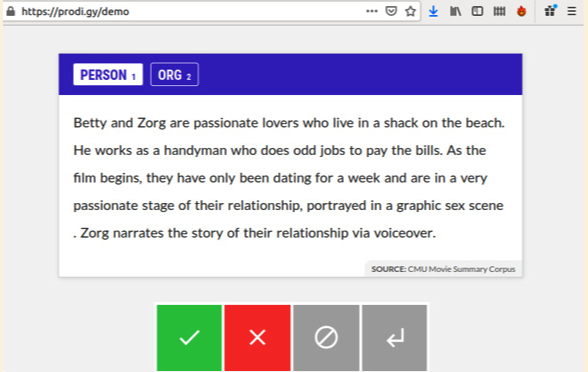

In [202]:
from IPython.display import Image
Image('images/prodigy1.PNG')

A captura de tela anterior mostra um texto de exemplo que queremos anotar. Os botões na parte inferior da captura de tela mostram os meios para aceitar este exemplo de treinamento, rejeitar este exemplo ou ignorar este exemplo. Se o exemplo for irrelevante para nosso domínio/tarefa (mas estiver envolvido no conjunto de dados de alguma forma), ignoramos este exemplo. Se o texto for relevante e a anotação for boa, aceitamos este exemplo e ele se junta ao nosso conjunto de dados.

2. Em seguida, rotularemos as entidades. Rotular uma entidade é fácil. Primeiro, selecionamos um tipo de entidade na barra superior (aqui, esse corpus inclui dois tipos de entidades, **PERSON** e **ORG**. As entidades que você deseja anotar dependem de você; esses são os rótulos que você fornece à ferramenta). Então, vamos apenas selecionar as palavras que queremos rotular como uma entidade com o cursor, como visto na captura de tela a seguir:

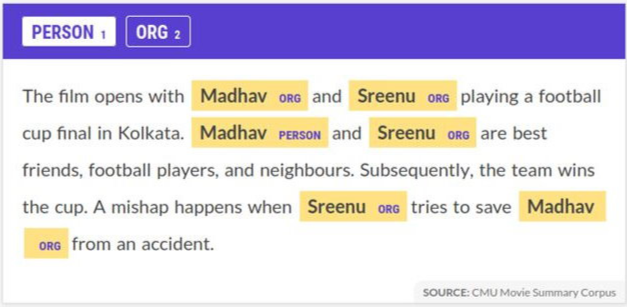

In [203]:
Image('images/prodigy2.PNG')

Após terminarmos de anotar o texto, clicamos no botão aceitar. Quando a sessão for concluída, você poderá despejar os dados anotados como um arquivo JSON. Quando terminar o trabalho de anotação, você pode clicar no botão **Salvar** para finalizar a sessão corretamente. Clicar em **Salvar** despejará os dados anotados como um arquivo JSON automaticamente. É isso. O Prodigy oferece uma maneira realmente eficiente de anotar seus dados.

### Anotando dados com Brat
Outra ferramenta de anotação é o **Brat**, que é uma ferramenta gratuita e baseada na web para anotação de texto (https://brat.nlplab.org/introduction.html). É possível anotar relações e entidades no Brat. Você também pode baixar o Brat em sua máquina local e usá-lo para tarefas de anotação. Basicamente, você carrega seu conjunto de dados para o Brat e anota o texto na interface. A captura de tela a seguir mostra uma frase anotada de um exemplo de um conjunto de dados CoNLL:

<p><img src=https://brat.nlplab.org/img/annotation-example.png></p>

### Formato de dados de treinamento spaCy
Como observamos anteriormente, o código de treinamento spaCy funciona com o formato de arquivo JSON. Vamos ver os detalhes do treinamento do formato de dados. Para o NER, você precisa fornecer uma lista de pares de frases e suas anotações. Cada anotação deve incluir o tipo de entidade, a posição inicial da entidade em termos de caracteres e a posição final da entidade em termos de caracteres. Vejamos um exemplo de um conjunto de dados:

In [204]:
training_data = [
    ("I will visit you in Munich.", {"entities": [(20, 26, "GPE")]}),
    ("I'm going to Victoria's house.", {"entities": [(13, 23, "PERSON"), (24, 29, "GPE")]}),
    ("I go there.", {"entities": []})
]
training_data

[('I will visit you in Munich.', {'entities': [(20, 26, 'GPE')]}),
 ("I'm going to Victoria's house.",
  {'entities': [(13, 23, 'PERSON'), (24, 29, 'GPE')]}),
 ('I go there.', {'entities': []})]

Este conjunto de dados consiste em três pares de exemplo. Cada par de exemplo inclui uma frase como o primeiro elemento. O segundo elemento do par é uma lista de entidades anotadas. Na primeira frase de exemplo, há apenas uma entidade, **Munich**. O rótulo dessa entidade é **GPE** e começa na 20ª posição do caractere na frase e termina no 25º caractere. Da mesma forma, a segunda frase inclui duas entidades; uma é **PERSON**, de **Victoria**, e a segunda entidade é **GPE**, **house**. A terceira frase não inclui nenhuma entidade, portanto, a lista está vazia.

Não podemos alimentar o texto bruto e as anotações diretamente no spaCy. Em vez disso, precisamos criar um objeto **Example** para cada exemplo de treinamento. Vamos ver o código:

In [205]:
import spacy
from spacy.training import Example
nlp = spacy.load("en_core_web_md")
doc = nlp("I will visit you in Munich.")
annotations = {"entities": [(20, 26, "GPE")]}
example_sent = Example.from_dict(doc, annotations)
example_sent

{'doc_annotation': {'cats': {}, 'entities': ['O', 'O', 'O', 'O', 'O', 'U-GPE', 'O'], 'links': {}}, 'token_annotation': {'ORTH': ['I', 'will', 'visit', 'you', 'in', 'Munich', '.'], 'SPACY': [True, True, True, True, True, False, False], 'TAG': ['', '', '', '', '', '', ''], 'LEMMA': ['', '', '', '', '', '', ''], 'POS': ['', '', '', '', '', '', ''], 'MORPH': ['', '', '', '', '', '', ''], 'HEAD': [0, 1, 2, 3, 4, 5, 6], 'DEP': ['', '', '', '', '', '', ''], 'SENT_START': [1, 0, 0, 0, 0, 0, 0]}}

Neste segmento de código, primeiro, criamos um objeto **doc** a partir da frase de exemplo. Em seguida, alimentamos o objeto **doc** e suas anotações em um formulário de dicionário para criar um objeto **Example**. Usaremos objetos de **exemplo** no código de treinamento da próxima seção. Criar frases de exemplo para treinar o analisador de dependência é um pouco diferente, e abordaremos isso na seção *Treinando um componente de pipeline do zero*.

Agora, estamos prontos para treinar nossos próprios modelos espaciais. Veremos primeiro como atualizar um modelo estatístico de pipeline de NLP. Para isso, treinaremos ainda mais o componente NER com a ajuda de nossos próprios exemplos.

## Atualizando um componente de pipeline existente
Nesta seção, treinaremos o componente NER do spaCy com nossos próprios exemplos para reconhecer o domínio de navegação. Já vimos alguns exemplos de enunciados de domínio de navegação e como o modelo NER do spaCy rotulou entidades de alguns enunciados de exemplo:
~~~python
navigate/0 to/0 my/0 home/0
navigate/0 to/0 Oxford/FAC Street/FAC
~~~
Obviamente, queremos que o NER tenha um desempenho melhor e reconheça entidades de localização, como nomes de ruas, nomes de distritos e outros nomes de locais, como casa, trabalho e escritório. Agora, vamos alimentar nossos exemplos para o componente NER e fazer mais treinamento. Treinaremos o NER em três etapas:

1. Primeiro, desabilitaremos todos os outros componentes estatísticos do pipeline, incluindo o tagger POS e o analisador de dependência.
2. Vamos alimentar nossos exemplos de domínio para o procedimento de treinamento.
3. Avaliaremos o novo modelo NER.

Além disso, aprenderemos como fazer o seguinte:
* Salvar o modelo NER atualizado em disco.
* Ler o modelo NER atualizado quando quisermos usá-lo.

Vamos começar e mergulhar no treinamento do procedimento do modelo NER. Como apontamos na lista anterior, treinaremos o modelo NER em várias etapas. Começaremos com o primeiro passo, desabilitando os outros modelos estatísticos do pipeline spaCy NLP.

### Desabilitando os outros modelos estatísticos
Antes de iniciar o procedimento de treinamento, desabilitamos os outros componentes do pipeline, portanto treinamos **apenas** o componente pretendido. O segmento de código a seguir desabilita todos os componentes do pipeline, exceto NER. Chamamos este bloco de código antes de iniciar o procedimento de treinamento:

In [206]:
other_pipes = [pipe for pipe in nlp.pipe_names if pipe != 'ner']
nlp.disable_pipes(*other_pipes)


['tok2vec', 'tagger', 'parser', 'attribute_ruler', 'lemmatizer']

Outra maneira de escrever este código é a seguinte:
~~~python
other_pipes = [pipe for pipe in nlp.pipe_names if pipe != 'ner']
with nlp.disable_pipes(*other_pipes):
		# training code goes here
~~~
No bloco de código anterior, usamos o fato de que **nlp.disable_pipes** retorna um gerenciador de contexto. Usar uma instrução **with** garante que nosso código libere as fontes alocadas (como manipuladores de arquivos, bloqueios de banco de dados ou vários threads). Se você não estiver familiarizado com instruções, leia mais neste tutorial do Python: https://book.pythontips.com/en/latest/context_managers.html.

Concluímos a primeira etapa do código de treinamento. Agora, estamos prontos para fazer o procedimento de treinamento do modelo.

### Procedimento de treinamento do modelo
Como mencionamos no Capítulo 3, Recursos linguísticos, na seção Introdução ao reconhecimento de entidade nomeada, o modelo NER do spaCy é um modelo de rede neural. Para treinar uma rede neural, precisamos configurar alguns parâmetros, bem como fornecer exemplos de treinamento. Cada previsão da rede neural é uma soma de seus valores de **peso**; portanto, o procedimento de treinamento ajusta os pesos da rede neural com nossos exemplos. Se você quiser saber mais sobre como as redes neurais funcionam, leia o excelente guia em http://neuralnetworksanddeeplearning.com/.

No procedimento de treinamento, revisaremos o conjunto de treinamento várias vezes e mostraremos cada exemplo várias vezes (uma iteração é chamada de uma **epoch**) porque mostrar um exemplo apenas uma vez não é suficiente. A cada iteração, embaralhamos os dados de treinamento para que a ordem dos dados de treinamento não importe. Esse embaralhamento de dados de treinamento ajuda a treinar a rede neural completamente.

Em cada *epoch*, o código de treinamento atualiza os pesos da rede neural com um número pequeno. Otimizadores são funções que atualizam os pesos da rede neural sujeitos a uma perda. Na *epoch*, um valor de perda é calculado comparando o rótulo real com a saída atual da rede neural. Então, a função do otimizador pode atualizar o peso da rede neural em relação a esse valor de perda.

No código a seguir, usamos o algoritmo **estocástico gradiente descendente (SGD)** como otimizador. O próprio SGD também é um algoritmo iterativo. Ele visa minimizar uma função (para redes neurais, queremos minimizar a função de perda). O SGD começa a partir de um ponto aleatório na função de perda e percorre sua inclinação em etapas até atingir o ponto mais baixo dessa função. Se você quiser saber mais sobre SGD, visite a excelente aula de rede neural de Stanford em http://deeplearning.stanford.edu/tutorial/supervised/OptimizationStochastic GradientDescent/.

Colocando tudo junto, aqui está o código para treinar o modelo NER do spaCy para o domínio de navegação. Vamos passo a passo:
1. Nas três primeiras linhas, fazemos as importações necessárias. **random** é uma biblioteca Python que inclui métodos para geradores pseudo-aleatórios para várias distribuições, incluindo distribuições uniforme, gama e beta. Em nosso código, usaremos **random.shuffle** para embaralhar nosso conjunto de dados. **shuffle** embaralha as sequências no lugar:

In [207]:
import random
import spacy
from spacy.training import Example

2. Em seguida, criaremos um objeto pipeline de linguagem, **nlp**:

In [208]:
nlp = spacy.load("en_core_web_md")

3. Em seguida, definiremos as sentenças do conjunto de treinamento do nosso domínio de navegação. Cada exemplo contém uma frase e sua anotação:

In [209]:
trainset = [
    ("navigate home", {"entities": [(9,13, "GPE")]}),
    ("navigate to office", {"entities": [(12,18,"GPE")]}),
    ("navigate", {"entities": []}),
    ("navigate to Oxford Street", {"entities": [(12,25, "GPE")]})
]

4. Queremos iterar nossos dados 20 vezes, portanto, o número de *epochs* é **20**:

In [210]:
epochs = 20

5. Nas próximas 2 linhas, desabilitamos os outros componentes do pipeline e deixamos o NER para treinamento. Usamos **with statement** para invocar **nlp.disable_pipe** como gerenciador de contexto:
~~~python
other_pipes = [pipe for pipe in nlp.pipe_names if pipe != 'ner']
with nlp.disable_pipes(*other_pipes):
	# Something
~~~

6. Criamos um objeto **otimizer**, conforme discutimos anteriormente. Vamos alimentar este objeto **otimizer** para o método de treinamento como um parâmetro:

In [211]:
optimizer = nlp.create_optimizer()

7. Então, para cada *epoch*, vamos embaralhar nosso conjunto de dados por **random.shuffle**:
~~~python
for i in range(epochs):
	random.shuffle(trainset)
~~~
8. Para cada frase de exemplo no conjunto de dados, criaremos um objeto de exemplo da frase e sua anotação:

`example = Example.from_dict(doc, annotation)`

9. Alimentaremos o objeto **Example** e o objeto **otimizer** para **nlp.update**. O método de treinamento real é **nlp.update**. Este é o lugar onde o modelo NER é treinado:

`nlp.update([example], sgd=optimizer)`

10. Quando as épocas estiverem completas, salvamos o componente NER recém-treinado em disco em um diretório chamado **navi_ner**:
~~~python
ner = nlp.get_pipe("ner")
ner.to_disk("navi_ner")
~~~

**nlp.update** gera um valor de perda cada vez que é chamado. Depois de invocar esse código, você deverá ver uma saída semelhante à captura de tela a seguir (os valores de perda podem ser diferentes):

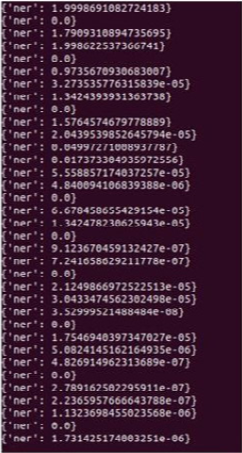

In [212]:
Image("images/NER_training.PNG")

In [213]:
import random
import spacy
from spacy.training import Example

nlp = spacy.load("en_core_web_md")

trainset = [
    ("navigate home", {"entities": [(9,13, "GPE")]}),
    ("navigate to office", {"entities": [(12,18,"GPE")]}),
    ("navigate", {"entities": []}),
    ("navigate to Oxford Street", {"entities": [(12,25, "GPE")]})
]

epochs = 20

other_pipes = [pipe for pipe in nlp.pipe_names if pipe != 'ner']

with nlp.disable_pipes(*other_pipes):
    optimizer = nlp.create_optimizer()
    for i in range(epochs):
	    random.shuffle(trainset)
	    for doc in trainset:
		    annotation = doc[1]
		    example = Example.from_dict(nlp(doc[0]), annotation)
		    nlp.update([example], sgd=optimizer)
    ner = nlp.get_pipe("ner")

É isso! Treinamos o componente NER para o domínio de navegação! Vamos tentar algumas frases de exemplo e ver se realmente funcionou.

### Avaliando o NER atualizado

Agora podemos testar nosso novo componente NER atualizado. Podemos tentar alguns exemplos com sinônimos e paráfrases para testar se a rede neural realmente aprendeu o domínio de navegação, em vez de memorizar nossos exemplos. Vamos ver como acontece:
1. Estas são as frases de treinamento:
~~~python
navigate home
navigate to office
navigate
navigate to Oxford Street
~~~

2. Vamos usar o sinônimo **house** para **home** e também adicionar mais duas palavras **to my**:

In [214]:
doc= nlp("navigate to my house")
doc.ents

(house,)

In [215]:
doc.ents[0].label_
'GPE'

'GPE'

3. Funcionou! **House** é reconhecido como uma entidade do tipo **GPE**. Que tal substituir navegar por um verbo semelhante, conduzir-me e criar uma paráfrase da primeira frase de exemplo:

In [216]:
doc= nlp("drive me to home")
doc.ents

(home,)

In [217]:
doc.ents[0].label_

'GPE'

4. Agora, tentamos uma frase ligeiramente diferente. Na próxima frase, não usaremos sinônimo ou paráfrase. Vamos substituir **Oxford Street** por um nome de distrito, **Soho**. Vamos ver o que acontece desta vez:

In [218]:
doc= nlp("navigate to Soho")
doc.ents

(Soho,)

In [219]:
doc.ents[0].label_

'GPE'

5. Como comentamos anteriormente, atualizamos o modelo estatístico, portanto, o modelo NER não esqueceu das entidades que já conhecia. Vamos fazer um teste com outro tipo de entidade para ver se o modelo NER realmente não esqueceu os outros tipos de entidade:

In [220]:
doc = nlp("I watched a documentary about Lady Diana.")
doc.ents

(Lady Diana,)

In [221]:
doc.ents[0].label_

'PERSON'

Excelente! As redes neurais do spaCy podem reconhecer não apenas sinônimos, mas entidades do mesmo tipo. Esta é uma das razões pelas quais usamos spaCy para PNL. Os modelos estatísticos são incrivelmente poderosos.

Na próxima seção, aprenderemos como salvar o modelo que treinamos e carregar um modelo em nossos scripts Python.

### Salvando e carregando modelos personalizados
No segmento de código anterior, já vimos como serializar o componente NER atualizado da seguinte forma:
~~~python
ner = nlp.get_pipe("ner")
ner.to_disk("navi_ner")
~~~

Serializamos modelos para que possamos carregá-los em outros scripts Python sempre que quisermos. Quando queremos fazer upload de um componente spaCy personalizado, realizamos as seguintes etapas:

In [234]:
import spacy
nlp = spacy.load("en_core_web_sm", disable=["ner"])
ner = nlp.create_pipe("ner")
print(nlp.meta['pipeline'])

['tok2vec', 'tagger', 'parser', 'attribute_ruler', 'lemmatizer']


Aqui estão os passos que seguimos:
1. Primeiro carregamos os componentes do pipeline sem o NER, porque queremos adicionar nosso NER personalizado. Dessa forma, garantimos que o NER padrão não substitua nosso componente NER personalizado.
2. Em seguida, criamos um objeto de componente de pipeline NER. Em seguida, carregamos nosso componente NER personalizado do diretório que serializamos para esse objeto de componente recém-criado.
3. Em seguida, adicionamos nosso componente NER personalizado ao pipeline.
4. Imprimimos os metadados do pipeline para garantir que o carregamento de nosso componente personalizado funcionou.

Agora, também aprendemos como serializar e carregar componentes personalizados. Assim, podemos avançar para uma missão maior: treinar um modelo estatístico espacial do zero. Vamos treinar novamente o componente NER, mas desta vez vamos começar do zero.